In [139]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'

# -------------------------------- parameters ---------------------------------------
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [2000]
from multiprocessing import Pool
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))

In [116]:
f = h5py.File(pred_file, 'r') # only key is main
preds = f['main']
print preds.shape

(3, 125, 1250, 1250)


# Divide Volumes, set up args

In [ ]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    print "calculating",seg_save_path,"watershed"
    # zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"

In [126]:
MAX_LEN = 400
dims = np.array((preds.shape[1:50]))
print "dims",dims
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts = []
ends = []
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(2): # len(starts)):
    s = starts[i]
    e = ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [ 125 1250 1250]
num_vols [1 4 4]
deltas [125 312 312]
[0 0 0] [129 313 313] (3, 125, 313, 313)
[  0   0 312] [129 313 625] (3, 125, 313, 313)


# Call Watershed

In [127]:
p = Pool(2)
print(p.map(zwshed_h5_par, args))

[None, None]
calculating /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_312/ watershed
finishedfinished /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
 /nobackup/turaga/singhc/par_zwshed/0_0_312/ watershed


# Visualize

In [136]:
for arg in args:
    for filename in os.listdir(arg[2]):
        seg_h5 = h5py.File(arg[2]+filename,'r')
        seg = seg_h5['main']
        print arg[2],seg.shape

/nobackup/turaga/singhc/par_zwshed/0_0_0/ (125, 313, 313)
/nobackup/turaga/singhc/par_zwshed/0_0_312/ (125, 313, 313)


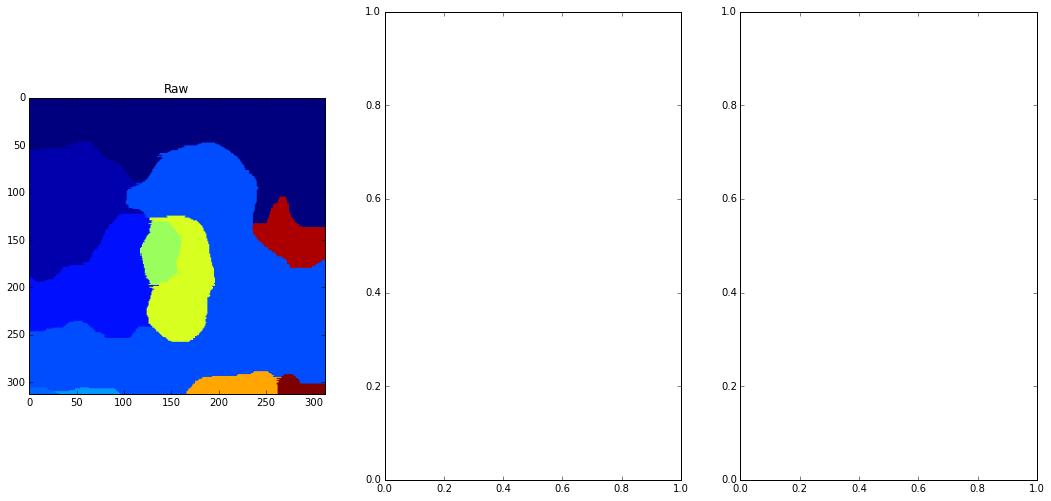

In [141]:
def display_affs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    ax1.set_title('Raw')
    plt.show()
def display_segs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[1, :, :])
    ax1.set_title('Raw')
    plt.show()
# display_arbitrary(preds,preds,preds)
display_segs(seg,seg,seg)

In [118]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'/'

In [122]:
def f(x):
    return x*x



[1, 4, 9]
